# Project 2
Kai Bagley - 21984315

* Data Exploration
* Preprocessing, and
* Task 1

### Objective

I will be trying two different language models on two NLP tasks: Document Classification and Entity Recognition.

This will be done on the US Mining Safety Logs data set, which records the injuries of employees working in the mining industry. This dataset includes the structured fields (and more):

* `NATURE_INJURY`: Nature of the injury, eg. `SPRAIN`.
* `INJ_BODY_PART`: Injured body part, eg. `HEAD`.
* `ACTIVITY`: Activity that was being done at the time of injury, eg. `HAND_TOOLS`.
* `INJURY_SOURCE`: Source of injury, eg. `AXE`.

There is also a `NARRATIVE` field that contains unstructured short texts describing the incident in detail. This ifield contains valuable information which could help improve workplace safety.

I will be attempting to retrieve useful information from the narratives using document classification and entity recognition.

## Data Exploration

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

#### Load data

In [2]:
cols = ["DEGREE_INJURY", 
        "DEGREE_INJURY_CD",
        "NATURE_INJURY",
        "NATURE_INJURY_CD",
        "INJ_BODY_PART",
        "INJ_BODY_PART_CD",
        "ACTIVITY",
        "ACTIVITY_CD",
        "INJURY_SOURCE",
        "INJURY_SOURCE_CD",
        "NARRATIVE"]

df = pd.read_csv("./data/us_data_2000.csv", usecols=cols)
df.head()

,DEGREE_INJURY_CD,DEGREE_INJURY,ACTIVITY_CD,ACTIVITY,INJURY_SOURCE_CD,INJURY_SOURCE,NATURE_INJURY_CD,NATURE_INJURY,INJ_BODY_PART_CD,INJ_BODY_PART,NARRATIVE
0,5,DAYS RESTRICTED ACTIVITY ONLY,28,HANDLING SUPPLIES/MATERIALS,76,SURFACE MINING MACHINES,160,"CONTUSN,BRUISE,INTAC SKIN",700,MULTIPLE PARTS (MORE THAN ONE MAJOR),Employee was cleaning up at the Primary Crushe...
1,6,"NO DYS AWY FRM WRK,NO RSTR ACT",30,HAND TOOLS (NOT POWERED),46,"AXE,HAMMER,SLEDGE",180,"CUT,LACER,PUNCT-OPN WOUND",100,"HEAD,NEC",Handle of sledgehammer broke and head of hamme...
2,3,DAYS AWAY FROM WORK ONLY,13,CLIMB SCAFFOLDS/LADDERS/PLATFORMS,117,GROUND,330,"SPRAIN,STRAIN RUPT DISC",520,ANKLE,EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...
3,5,DAYS RESTRICTED ACTIVITY ONLY,28,HANDLING SUPPLIES/MATERIALS,4,BAGS,330,"SPRAIN,STRAIN RUPT DISC",420,BACK (MUSCLES/SPINE/S-CORD/TAILBONE),HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...
4,5,DAYS RESTRICTED ACTIVITY ONLY,96,WORKING WITH CHEMICALS,21,"ACIDS,ALKALI,WET CEMENT",130,"BURN,CHEMICL-FUME,COMPOUN",330,HAND (NOT WRIST OR FINGERS),EE hands began to break out in a rash after he...


#### Train/Test Split

This step requires a 80/20 Train/Test split, but also requires a validation set. The way I interpret this requirement is to do a 80/20 split to give `train` and `test` sets, and then I will take another 20% split from the `train` set to give `train` and `valid`. `train` will be overwritten such that the split is actually 60/20/20 train/test/valid.

Before we do any of that, I will first drop any `na` occurences, and any with a class label `?`.

In [3]:
df = df[df["NARRATIVE"].notnull()]

df = df.drop(df[df["DEGREE_INJURY_CD"]=="?"].index)
df = df.drop(df[df["ACTIVITY_CD"]=="?"].index)

Since task 1 is a binary classification problem, the first class will contain all incidents where the accident was known to impact the activity of the person (eg. `FATALITY`, `DAYS_RESTRICTED_ACTIVITY_ONLY`, etc), and the second class will be everything else (unknown impact `ACCIDENT_ONLY` etc. included). Task 1 only requires `NARRATIVE`, `DEGREE_INJURY` and `DEGREE_INJURY_CD` only.

#### Task 1 Preprocessing

In [4]:
# Get rows where injury code = [1, 2, 3, 4, 5] (described above)
cls0 = ["1", "2", "3", "4", "5"]
cls1 = [str(x) for x in range(13) if x not in cls0]

binary_class_dict = {1:"Serious Injury", 0:"Non-Serious Injury"}

task1_df = df[["DEGREE_INJURY_CD", "DEGREE_INJURY", "NARRATIVE"]].copy()
task1_df["DEGREE_INJURY_CD"].replace(cls0, 0, inplace=True)
task1_df["DEGREE_INJURY_CD"].replace(cls1, 1, inplace=True)

# Train, test and valid sets
train1, test1  = train_test_split(task1_df, train_size=0.8)
train1, valid1 = train_test_split(train1, train_size=0.8)

# Write dataframes to CSV
train1.to_csv("./data/task1/train.csv")
test1.to_csv("./data/task1/test.csv")
valid1.to_csv("./data/task1/valid.csv")

task1_df.head()

,DEGREE_INJURY_CD,DEGREE_INJURY,NARRATIVE
0,0,DAYS RESTRICTED ACTIVITY ONLY,Employee was cleaning up at the Primary Crushe...
1,1,"NO DYS AWY FRM WRK,NO RSTR ACT",Handle of sledgehammer broke and head of hamme...
2,0,DAYS AWAY FROM WORK ONLY,EMPLOYEE WAS CLIMBING DOWN A LADDER AND WHEN H...
3,0,DAYS RESTRICTED ACTIVITY ONLY,HE PULLED A BACK MUSCLE WHILE STACKING BAGS OF...
4,0,DAYS RESTRICTED ACTIVITY ONLY,EE hands began to break out in a rash after he...


#### Task 2 Preprocessing

Task 2 requires multiclass classification. Below are all the relevant columns, but for the classification I will be using `ACTIVITY` as the class labels (In particular, the code `_CD` values):

* `NATURE_INJURY`
* `INJ_BODY_PART`
* `ACTIVITY`
* `INJURY_SOURCE`
* `NARRATIVE`

Since there are classes with very few occurences, sometimes the vectorizer will not be able to add every class to the vocabulary, so we can avoid this by removing observations with very infrequent classes, and then using `stratify` in the `train_test_split` call, which will retain the class proportions when returning the splits. 

In [5]:
task2cols = ["ACTIVITY", "ACTIVITY_CD", "NARRATIVE"]
task2_df = df[task2cols]

# Drop underrepresented classes, threshold = 20
task2_df = task2_df.groupby("ACTIVITY_CD").filter(lambda x: len(x)>20)

x_a, x_b, y_a, y_b = train_test_split(task2_df["NARRATIVE"], task2_df["ACTIVITY_CD"], train_size=0.8, stratify=task2_df["ACTIVITY_CD"])
test2 = pd.concat([x_b, y_b], axis=1)
x_a, x_b, y_a, y_b = train_test_split(x_a, y_a, train_size=0.8, stratify=y_a)
train2 = pd.concat([x_a, y_a], axis=1)
valid2 = pd.concat([x_b, y_b], axis=1)

# Write dataframes to CSV
train2.to_csv("./data/task2/train.csv")
test2.to_csv("./data/task2/test.csv")
valid2.to_csv("./data/task2/valid.csv")

valid2

,NARRATIVE,ACTIVITY_CD
471,EE OPENED DOOR TO GET OUT OF TRUCK WHICH WAS O...,23
152,EE assisting in mill liner job. Liner on dolly...,28
1674,Emp. lifted tool box out of truck and felt pai...,28
412,Employee slipped off the last rung of a ladder...,41
1447,EE STATED HE PUSHED DOWN WITH A BAR ON A KILN ...,30
...,...,...
568,Employee was dismounting from skid steer. He ...,23
1459,EE WAS COMING TO WORK & STEPPED OFF SIDEWALK H...,92
363,During the raising process the workdeck winche...,23
1828,EMPLOYEE STEPPED OUT OF BUCKET TRUCK AND TWIST...,23


#### Visualising the class balance

In [6]:
inj_counts = df["DEGREE_INJURY"].value_counts()

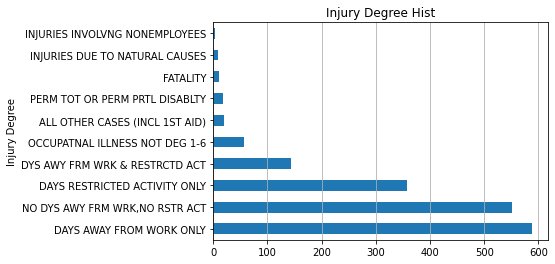

In [7]:
fig, ax = plt.subplots()

ax = inj_counts.plot(kind="barh")
ax.set_title("Injury Degree Hist")
ax.set_ylabel("Injury Degree")
ax.xaxis.grid(True)

plt.show()

#### Visualise the entity distribution

In [8]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

This cell may take a very long time if run on a large dataset, so we will only use up to the first 2000 observations as a sample of the data.

In [9]:
ner_data = df.iloc[:2000]
ne_narr  = list(nlp.pipe(ner_data["NARRATIVE"]))

In [10]:
ne = []
for doc in ne_narr:
    ne.append([(x.text, x.label_) for x in doc.ents])
ne_counts = pd.DataFrame([a for b in ne for a in b])[1].value_counts()

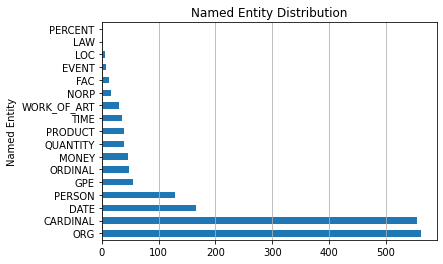

In [11]:
fig, ax = plt.subplots()

ax = ne_counts.plot(kind="barh")
ax.set_title("Named Entity Distribution")
ax.set_ylabel("Named Entity")
ax.xaxis.grid(True)

plt.show()

## Data Preprocessing and Preparation

Create a dataset for each task, and two Vectorizers (one for one-hot, and another pre-trained embedding). Follow the pre-processing steps:

* Tokenize
* Lemmatize, compare with stemming
* Remove stop words (rank according to tf-idf)

Tokenization will be done automatically in the `Vocabulary` class, in the `add_token`/`add_tokens` methods.

I will define a function below for finding stopwords, by using the `sklearn` class `TfidfVectorizer` on the narratives.

Both the removal of stopwords and lemmatization will occur in the `NarrativeDataset` class, in method `load_dataset_make_vectorizer`.

#### Pretrained Embeddings

Pretrained embeddings will only be used in conjunction with the vectorizer class `PEVectorizer`, as they will not be usable with a vectorizer that encodes into one-hot vectors. These embeddings will be imported using glove, from the file `glove.6B.100d.txt`, a 100-dimensional, 6-billion token file of word vectors. These are learned from a dump of Wikipedia in 2014, and the Gigaword 5 archive.

For the most part, the embeddings are handled within the classifier classes themselves, but for Task 1 it was a bit different. For this task, the MLP doesn't use any embedding, it just takes the one-hot vectorized words, but the CNN does take embeddings. It can take pretrained or do the embeddings itself depending on the argument in the `args` namespace: `use_glove`. If `True`, then it uses the above GloVe embeddings, if `False` it will use it's own embeddings.

#### Stopword Removal

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df["NARRATIVE"])

In [13]:
features  = np.array(tfidf_vectorizer.get_feature_names())
sums = tfidf.sum(axis=0)

data = []
for col, feature in enumerate(features):
    data.append((feature, sums[0, col]))
    
ranking = pd.DataFrame(data, columns=["features", "rank"])

stopwords = list(ranking.sort_values('rank', ascending=False)[:50]["features"])
print(stopwords)

['the', 'was', 'and', 'his', 'on', 'to', 'he', 'employee', 'of', 'in', 'ee', 'when', 'left', 'back', 'right', 'while', 'hand', 'fell', 'from', 'slipped', 'finger', 'with', 'rock', 'off', 'it', 'causing', 'piece', 'up', 'pain', 'out', 'felt', 'truck', 'knee', 'that', 'him', 'into', 'at', 'down', 'belt', 'work', 'hit', 'cut', 'struck', 'for', 'between', 'lower', 'as', 'not', 'foot', 'had']


## Task 1: Binary Document Classification

#### Define `Task1Dataset` class

This class was mostly taken from the lab notes, with a few changes made to suit the dataset

In [14]:
from torch.utils.data import Dataset

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

class Task1Dataset(Dataset):
    def __init__(self, train_df, test_df, valid_df, vectorizer):
        """
        Args:
            train_df (pandas.DataFrame): Training dataset
            test_df (pandas.DataFrame): Test dataset
            valid_df (pandas.DataFrame): Validation dataset
            vectorizer (object): Vectorizer created from dataset
        """
        self._vectorizer = vectorizer
        
        self.train_df = train_df
        self.train_size = len(self.train_df)
        
        self.test_df = test_df
        self.test_size = len(self.test_df)
        
        self.valid_df = valid_df
        self.valid_size = len(self.valid_df)
        
        self.df = train_df.append(test_df).append(valid_df)
        
        # +2 for end and begin tokens
        measure_len = lambda sent: len(sent.split(" "))
        self._max_seq_length = max(map(measure_len, self.df["NARRATIVE"])) + 2
        
        self._lookup_dict = {"train": (self.train_df, self.train_size),
                             "test": (self.test_df, self.test_size),
                             "valid": (self.valid_df, self.valid_size)}
        self.set_split("train")
        
    @classmethod
    def load_dataset_make_vectorizer(cls, folder_path, vectorizer):
        """Load dataset and make a new vectorizer from it
        Args:
            csv (str): Path to folder containing data CSVs
            vectorizer (object): One of the two Vectorizer classes,
                OHVectorizer for one hot, or 
                PEVectorizer for use with pretrained embeddings
        Returns:
            Instance of Task1Dataset
        """
        train_df = pd.read_csv(folder_path + "train.csv")
        test_df = pd.read_csv(folder_path + "test.csv")
        valid_df = pd.read_csv(folder_path + "valid.csv")
        
        # Remove stopwords
        for x in [train_df, test_df, valid_df]:
            x["NARRATIVE"] = x["NARRATIVE"].str.lower().apply(lambda x:" ".join([w for w in x.split(" ") if w not in stopwords]))
        
        # Lemmatize
        for x in [train_df, test_df, valid_df]:
            x["NARRATIVE"] = x["NARRATIVE"].apply(lambda x:" ".join([lemmatizer.lemmatize(w) for w in x.split(" ")]))
        
        return cls(train_df, test_df, valid_df, vectorizer.from_dataframe(train_df))
    
    def get_vectorizer(self):
        """Returns vectorizer"""
        return self._vectorizer
    
    def set_split(self, split="train"):
        """Selects the chosen dataset
        Args: 
            split (str): Select "train", "test", "valid"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """Allow indexing of dataset
        Args:
            index (int): Index of desired datapoint
        Returns:
            Dictionary with datapoint's features and labels
        """
        row = self._target_df.iloc[index]

        narr_vector = self._vectorizer.vectorize(row["NARRATIVE"], self._max_seq_length)
        injurycd_idx = self._vectorizer.injury_codes.lookup_token(row["DEGREE_INJURY_CD"])
        return {"features":narr_vector,
                "labels":injurycd_idx}

    def get_num_batches(self, batch_size):
        """Return number of batches in dataset from a given batch size
        Args:
            batch_size (int)
        Returns:
            Number of batches in the dataset
        """
        return len(self) // batch_size

#### Create a dataloader

Groups the vectorized datapoints

In [15]:
from torch.utils.data import DataLoader
def gen_batches(dataset, batch_size, shuffle=True, drop_last=True, device="cpu"):
    """Generator function, wraps PyTorch DataLoader and ensures 
    each tensor is in the right device
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last)
    
    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

#### Vocabulary

Base vocabulary class

In [16]:
class Vocabulary(object):
    """Processes text and extracts vocab"""
    def __init__(self, tok_to_idx=None):
        """Args:
            tok_to_idx (dict): Dictionary that maps tokens to indices
        """
        if tok_to_idx is None:
            tok_to_idx = {}
        self._tok_to_idx = tok_to_idx
        self._idx_to_tok = {idx:token for token, idx in self._tok_to_idx.items()}

    def to_serializable(self):
        return {"tok_to_idx":self._tok_to_idx}

    @classmethod
    def from_serializable(cls, dictionary):
        """Creates a Vocabulary from a serialized dict"""
        return cls(**dictionary)

    def add_token(self, token):
        """Update Vocabulary with a new token

        Args:
            token (str): The token to add to the Vocabulary
        Returns:
            index (int): Integer index corresponding to the token 
        """

        if token in self._tok_to_idx:
            index = self._tok_to_idx[token]
        else:
            index = len(self._tok_to_idx)
            self._tok_to_idx[token] = index
            self._idx_to_tok[index] = token
        return index

    def add_tokens(self, tokens):
        """Updates Vocabulary with multiple tokens

        Args: 
            tokens (list): List of tokens (str)s
        Returns:
            indices (list): List of indices (int)s
        """

        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Returns index of a token

        Args:
            token (str): Token to to find index for
        Returns:
            index (int): The index of the token
        """
        return self._tok_to_idx[token]

    def lookup_index(self, index):
        """Returns token at index

        Args:
            index (int): Index to search for
        Returns:
            token (str): Associated token
        """

        if index not in self._idx_to_tok:
            raise KeyError(f"Index ({index}) is not in the Vocabulary")
        return self._idx_to_tok[index]

    def __str__(self):
        return f"<Vocabulary(size={len(self)})>"

    def __len__(self):
        return len(self._tok_to_idx)

#### Sequence Vocabulary

Class for the narrative sentences as sequences of words, beginning and ending with special tokens. The class inherits from the `Vocabulary` class above. 

In [17]:
# The below Vocabulary object is from lab 9

class SequenceVocabulary(Vocabulary):
    """Processes text and extracts vocab, for sequences"""
    def __init__(self, add_unk=True, tok_to_idx=None, unk_token="<UNK>", mask_token="<MASK>", begin_seq_token="<BEGIN>", end_seq_token="<END>"):
        """Args:
            tok_to_idx (dict): Dictionary that maps tokens to indices
            unk_token (str): The UNK token that will be added to the Vocabulary
            mask_token (str): Used as padding for embedding
            begin_seq_token (str): Start of a sequence
            end_seq_token (str): End of a sequence
        """
        super(SequenceVocabulary, self).__init__(tok_to_idx)
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token
        
        self.unk_index = self.add_token(self._unk_token)
        self.mask_index = self.add_token(self._mask_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
    def to_serializable(self):
        return {"tok_to_idx":self._tok_to_idx,
                "unk_token":self._unk_token,
                "mask_token":self._mask_token,
                "begin_seq_token":self._begin_seq_token,
                "end_seq_token":self._end_seq_token}

    def lookup_token(self, token):
        """Returns index of a token, or <UNK> index if not present

        Args:
            token (str): Token to to find index for
        Returns:
            index (int): The index of the token
        """
        if self.unk_index >= 0:
            return self._tok_to_idx.get(token, self.unk_index)
        else:
            return self._tok_to_idx[token]

### Vectorizers

Vectorizer for use with one-hot encodings.

In [18]:
from collections import Counter
import string

class OHVectorizer(object):
    """One-Hot Vectorizer"""
    def __init__(self, narrative_vocab, injury_codes):
        """Args:
            narrative_vocab (Vocabulary): Vocab for the narrative feature
            injury_codes (Vocabulary): Injuries are already encoded as integers
        """
        self.narrative_vocab = narrative_vocab
        self.injury_codes = injury_codes
    
    def vectorize(self, narrative, vec_length=None):
        """Create one-hot encoding for the narrative
        
        Args:
            narrative (str): The narrative
        
        Returns:
            one_hot (np.ndarray): The one-hot encoding
        """
        
        one_hot = np.zeros(len(self.narrative_vocab), dtype=np.float32)
        for token in narrative.split(" "):
            if token not in string.punctuation:
                one_hot[self.narrative_vocab.lookup_token(token)] = 1
        return one_hot
    
    @classmethod
    def from_dataframe(cls, df, cutoff=0):
        """Create a one-hot vectorizer from a dataframe
        
        Args:
            narrative_df (pandas.DataFrame): Narrative dataframe
            injury_code_arr (arraylike): Array of injury codes 
            
        Returns:
            OHVectorizer object
        """
        
        word_counter = Counter()
        narrative_vocab = SequenceVocabulary(add_unk=True)
        for narrative in sorted(set(df["NARRATIVE"])):
            for token in narrative.split(" "):
                if token not in string.punctuation:
                    word_counter[token] += 1
                    
        for word, count in word_counter.items():
            if count > cutoff:
                narrative_vocab.add_token(word)
        
        injury_codes = Vocabulary()
        for code in sorted(set(df["DEGREE_INJURY_CD"])):
            injury_codes.add_token(code)
        
        return cls(narrative_vocab, injury_codes)

Vectorizer for embeddings, which are to be done in the classifier cells

In [19]:
class PEVectorizer(object):
    """Vectorizer for use with the pretrained embeddings"""
    def __init__(self, narrative_vocab, injury_codes):
        """
        Args:
            narrative_vocab (Vocabulary): Vocab for the narrative feature
            injury_codes (Vocabulary): Injuries are already encoded as integers
        """
        self.narrative_vocab = narrative_vocab
        self.injury_codes = injury_codes
    
    def vectorize(self, narrative, vec_length=-1):
        """
        Args:
            narrative (str): The space-separated narrative
            vec_length (int): Fix length of vector
        Returns:
            out (np.ndarray): Vectorized narrative
        """
        idx = [self.narrative_vocab.begin_seq_index]
        idx.extend(self.narrative_vocab.lookup_token(token) for token in narrative.split(" "))
        idx.append(self.narrative_vocab.end_seq_index)
        
        if vec_length < 0:
            vec_length = len(idx)
            
        out = np.zeros(vec_length, dtype=np.int64)
        out[:len(idx)] = idx
        out[len(idx):] = self.narrative_vocab.mask_index
        
        return out
    
    @classmethod
    def from_dataframe(cls, df, cutoff=0):
        """Create a vectorizer from a dataframe
        
        Args:
            narrative_df (pandas.DataFrame): Narrative dataframe
            injury_code_arr (arraylike): Array of injury codes 
        Returns:
            PEVectorizer object
        """
        word_counter = Counter()
        narrative_vocab = SequenceVocabulary(add_unk=True)
        for narrative in sorted(set(df["NARRATIVE"])):
            for token in narrative.split(" "):
                if token not in string.punctuation:
                    word_counter[token] += 1
                    
        for word, count in word_counter.items():
            if count > cutoff:
                narrative_vocab.add_token(word)
        
        injury_codes = Vocabulary()
        for code in sorted(set(df["DEGREE_INJURY_CD"])):
            injury_codes.add_token(code)
        
        return cls(narrative_vocab, injury_codes)

### Feed-Forward NN model

A basic example of a feed-forward neural network is a simple multi-layer perceptron, with one hidden layer

In [20]:
class NarrativeFFClassifier(nn.Module):
    """Multilayer Perceptron classifier"""
    def __init__(self, num_features, hidden_size):
        """
        Args:
            num_features (int): Size of input
            hidden_size (int): Size of hidden layer
        """
        super(NarrativeFFClassifier, self).__init__()
        
        self.num_features = num_features
        self.hidden_size = hidden_size
        
        self.dense1  = nn.Linear(self.num_features, self.hidden_size)
        self.relu    = nn.ReLU()
        self.dense2  = nn.Linear(self.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs, apply_sigmoid=False):
        """Forward pass
        Args:
            inputs (torch.Tensor): Input data tensor, inputs.shape = (batch_size, num_features)
            apply_sigmoid (bool): True to use sigmoid activation function
        Returns:
            Output tensor, tensor.shape = (batch,)
        """
        x = self.dense1(inputs)
        x = self.relu(x)
        x = self.dense2(x).squeeze()
        if apply_sigmoid:
            x = torch.sigmoid(x)
        
        return x

Define arguments to be used in the first model using `Namespace`

In [21]:
from argparse import Namespace
args = Namespace(
    frequency_cutoff=0,
    narrative_folder_path="./data/task1/",
    model_state_file="./data/task1/MLPmodel.pth",
    vectorizer_file="./data/task1/MLPvectorizer.json",
    save_dir="./data/task1/",
    glove_file="./data/glove.6B/glove.6B.100d.txt",
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=9,
    # Runtime options
    cuda=True,
    device='cuda',
    use_glove=False,
    embedding_size=100
)

Define auxiliary functions

In [22]:
import torch.optim as optim

def make_train_state(args):
    return {"epoch_index": 0,
            "train_loss": [],
            "train_acc": [],
            "valid_loss": [],
            "valid_acc": [],
            "test_loss": 1,
            "test_acc": 1,
            "learning_rate":args.learning_rate,
            "stop_early":False,
            "early_stopping_step":0,
            "early_stopping_best_valid": 1e8,
            "model_filename": args.model_state_file}

def update_train_state(args, model, train_state):
    """Implements early stopping
    Args:
        args (Namespace): Main model arguments
        model (nn.Module): Model
        train_state (dict): Current training state
    """
    # Save first model
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(), train_state["model_filename"])
        train_state["stop_early"] = False
    
    # Save model if performance increase
    if train_state["epoch_index"] >= 1:
        _, loss = train_state["valid_loss"][-2:]
        
        # If loss increased
        if loss >= train_state["early_stopping_best_valid"]:
            train_state["early_stopping_step"] += 1
        # If loss decreased
        else:
            # Save best model
            if loss < train_state["early_stopping_best_valid"]:
                torch.save(model.state_dict(), train_state["model_filename"])
            
            train_state["early_stopping_step"] = 0
            
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
        
    return train_state

def compute_accuracy(y_pred, y_targ):
    y_targ = y_targ.cpu()
    y_pred_idx = (torch.sigmoid(y_pred)>0.5).cpu().long()
    n_correct = torch.eq(y_pred_idx, y_targ).sum().item()
    
    return n_correct / len(y_pred_idx) * 100

Define the important functions, such as the classifier, the loss function and the optimizer

In [23]:
train_state = make_train_state(args)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

dataset = Task1Dataset.load_dataset_make_vectorizer(args.narrative_folder_path, OHVectorizer)
vectorizer = dataset.get_vectorizer()

num_features = len(vectorizer.narrative_vocab)
clf = NarrativeFFClassifier(num_features=num_features, hidden_size=num_features//2)
clf = clf.to(args.device)

loss_f = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(clf.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

#### Training

Below is the actual training algorithm, which may or may not take a long time depending on how many epochs, how large the dataset is, and how fast the computer is (or whether it has a CUDA enabled GPU or not). With the default settings (100 epochs), and on the `us_data_2000.csv` dataset, it takes around 2 minutes. On the `us_data` dataset, I'd estimate it would take a very very long time on my computer, (150MB vs 1.5MB, and epochs are over 100x as many batches), but maybe a couple hours on a computer with a CUDA enabled GPU/better CPU than that is in a laptop.

In [24]:
epoch_bar = tqdm(desc="Epoch", 
                 total=args.num_epochs, 
                 position=0)

dataset.set_split('train')
train_bar = tqdm(desc='Train Split', 
                 total=dataset.get_num_batches(args.batch_size), 
                 position=1, 
                 leave=True)

for epoch_index in range(args.num_epochs):
    train_state["epoch_index"] = epoch_index
    
    # Training dataset
    dataset.set_split("train")
    batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    clf.train()
    for batch_index, batch_dict in enumerate(batch_gen):
        # Zero gradients
        optimizer.zero_grad()
        # Compute output
        y_pred = clf(inputs=batch_dict["features"].float())
        # Compute loss
        loss = loss_f(y_pred, batch_dict["labels"].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index+1)
        # Compute gradiends using loss
        loss.backward()
        # Use optimizer to take gradient step
        optimizer.step()
        # Compute accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
        running_acc += (acc_batch-running_acc) / (batch_index+1)
        
        # Update the bar
        train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
        train_bar.update()
            
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # Validation dataset
    dataset.set_split("valid")
    batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    clf.eval()
    
    for batch_index, batch_dict in enumerate(batch_gen):
        # Compute output
        y_pred = clf(inputs=batch_dict["features"].float())
        # Compute loss
        loss = loss_f(y_pred, batch_dict["labels"].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index+1)
        # Compute accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
        running_acc += (acc_batch-running_acc) / (batch_index+1)
        
    train_state["valid_loss"].append(running_loss)
    train_state["valid_acc"].append(running_acc)
    
    train_state = update_train_state(args=args, model=clf, train_state=train_state)

    scheduler.step(train_state['valid_loss'][-1])

    if train_state['stop_early']:
        print("stop")
        break
    
    train_bar.n=0
    epoch_bar.update()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train Split:   0%|          | 0/8 [00:00<?, ?it/s]

#### Evaluate model on test data

I can basically copy and paste the above validation split from the training stage above, and set the split to `test` to get the test accuracy and loss.

In [25]:
dataset.set_split("test")
batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
running_loss = 0.0
running_acc = 0.0
clf.eval()
for batch_index, batch_dict in enumerate(batch_gen):
    # Compute output
    y_pred = clf(inputs=batch_dict["features"].float())
    # Compute loss
    loss = loss_f(y_pred, batch_dict["labels"].float())
    loss_batch = loss.item()
    running_loss += (loss_batch-running_loss) / (batch_index+1)
    # Compute accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
    running_acc += (acc_batch-running_acc) / (batch_index+1)

train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [26]:
print(f"Test accuracy: {train_state['test_acc']}")
print(f"Test loss    : {train_state['test_loss']}")

Test accuracy: 69.921875
Test loss    : 0.8867103159427643


#### Test the model on new data points

In [27]:
import re
def preprocess_text(text):
    if type(text) == float:
        print(text)
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

def predict_injury(narrative, clf, vectorizer, decision_threshold=0.5):
    """Predict the injury degree
    Args:
        review (str): the narrative
        clf (NarrativeClassifier): the trained model
        vectorizer (OHVectorizer): the one-hot vectorizer
        decision_threshold (float): The numerical boundary which separates the rating classes
    """
    narrative = preprocess_text(narrative)
    vectorized_narr = torch.tensor(vectorizer.vectorize(narrative)).to(args.device)
    result = clf(vectorized_narr.view(1, -1))
    probability_value = torch.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0
    return vectorizer.injury_codes.lookup_index(index)

In [28]:
narr = "employee fell and hurt their hand"
prediction = predict_injury(narr, clf, vectorizer)
print("{} -> {}".format(narr, binary_class_dict[prediction]))

employee fell and hurt their hand -> Non-Serious Injury


#### Discussion

Clearly the above model is not fantastic, but at around 70% accuracy on the test set it's actually not quite as bad as I'd expect. The above example of a user-inputted narrative shows that the model may be seeing something about other words that lead to less serious injuries, as I struggled to make a sentence that it would classify as a Non-Serious Injury.

### `Conv1D` CNN model

Below is defined a basic CNN using `Conv1d` cells, for sequences. This model must take data vectorized by the `PEVectorizer` vectorizer, since it handles embeddings inside of its `__init__`.

In [29]:
class NarrativeCNNClassifier(nn.Module):
    """Narrative CNN Classifier"""
    def __init__(self, embedding_size, num_embeddings, num_channels, hidden_dim, num_classes, dropout_p, pretrained_embeddings=None, padding_idx=0):
        """
        Args:
            embedding_size (int): size of the embedding vectors
            num_embeddings (int): number of embedding vectors
            filter_width (int): width of the convolutional kernels
            num_channels (int): number of convolutional kernels per layer
            hidden_dim (int): the size of the hidden dimension
            num_classes (int): the number of classes in classification
            dropout_p (float): a dropout parameter 
            pretrained_embeddings (numpy.array): previously trained word embeddings default is None. If provided, 
            padding_idx (int): an index representing a null position
        """
        super(NarrativeCNNClassifier, self).__init__()
        
        if pretrained_embeddings is None:
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx)        
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.emb = nn.Embedding(embedding_dim=embedding_size,
                                    num_embeddings=num_embeddings,
                                    padding_idx=padding_idx,
                                    _weight=pretrained_embeddings)
        
        self.model = nn.Sequential(nn.Conv1d(in_channels=embedding_size,
                                             out_channels=num_channels,
                                             kernel_size=3),
                                   nn.ELU(),
                                   nn.Conv1d(in_channels=num_channels,
                                             out_channels=num_channels,
                                             kernel_size=3,
                                             stride=2),
                                   nn.ELU(),
                                   nn.Conv1d(in_channels=num_channels,
                                             out_channels=num_channels,
                                             kernel_size=3),
                                   nn.ELU()
                                  )
        
        self._dropout_p = dropout_p
        
        self.relu    = nn.ReLU()
        self.dense1  = nn.Linear(num_channels, hidden_dim)
        self.dense2  = nn.Linear(hidden_dim, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs, apply_sigmoid=False):
        """Forward pass
        Args:
            inputs (torch.Tensor): Input data tensor, inputs.shape = (batch_size, batch._max_seq_len)
            apply_sigmoid (bool): True to use sigmoid activation function
        Returns:
            Output tensor, tensor.shape = (batch, num_classes)
        """
        # inputs = (batch size, number of features)
        x_emb = self.emb(inputs).permute(0, 2, 1)
        # x embedded = ()
        
        x = self.model(x_emb)
        
        rem_size = x.size(dim=2)
        x = F.avg_pool1d(x, rem_size).squeeze(dim=2)
        x = F.dropout(x, p=self._dropout_p)
        
        x = self.dense1(x)
        x = F.dropout(x, p=self._dropout_p)
        x = self.relu(x)
        x = self.dense2(x)
        
        if apply_sigmoid:
            x = self.sigmoid(x)
        return x

Define arguments for the CNN

In [30]:
from argparse import Namespace
args = Namespace(
    frequency_cutoff=0,
    narrative_folder_path="./data/task1/",
    model_state_file="./data/task1/CNNmodel.pth",
    vectorizer_file="./data/task1/CNNvectorizer.json",
    save_dir="./data/task2/",
    glove_file="./data/glove.6B/glove.6B.100d.txt",
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=9,
    # Runtime options
    cuda=True,
    device='cuda',
    use_glove=False,
    embedding_size=100,
    dropout_p=0.1,
    num_channels=100,
    hidden_dim=5
)

Define/Redefine some auxiliary functions

In [31]:
import torch.optim as optim

def make_train_state(args):
    return {"epoch_index": 0,
            "train_loss": [],
            "train_acc": [],
            "valid_loss": [],
            "valid_acc": [],
            "test_loss": 1,
            "test_acc": 1,
            "learning_rate":args.learning_rate,
            "stop_early":False,
            "early_stopping_step":0,
            "early_stopping_best_valid": 1e8,
            "model_filename": args.model_state_file}

Since the CNN model can take embeddings, we can load predefined embeddings for the data from a file using GloVe. Below are the functions to load and prepare the embeddings for use. 

In [32]:
def load_glove(glove_file):
    """Load GloVe embeddings from a file
    Args:
        glove_file (str): path to the glove embeddings
    Returns:
        list:
            word_to_index (dict)
            embeddings (numpy.ndarray)
    """
    
    word_to_index = {}
    embeddings = []
    with open(glove_file, encoding="utf8") as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")
            word_to_index[line[0]] = index
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    return word_to_index, np.stack(embeddings)
    
def make_embedding_matrix(glove_file, words):
    """Create embedding matrix for a specific set of words.
    
    Args:
        glove_filepath (str): file path to the glove embeddings
        words (list): list of words in the dataset
    """
    word_to_idx, glove_embeddings = load_glove(glove_file)
    embedding_size = glove_embeddings.shape[1]
    
    final_embeddings = np.zeros((len(words), embedding_size))

    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = glove_embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.ones(1, embedding_size)
            torch.nn.init.xavier_uniform_(embedding_i)
            final_embeddings[i, :] = embedding_i

    return final_embeddings

In [33]:
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

args.use_glove = True

In [34]:
dataset = Task1Dataset.load_dataset_make_vectorizer(args.narrative_folder_path, PEVectorizer)
vectorizer = dataset.get_vectorizer()

Here is the loading of the embeddings, which then get passed into the classifier in the next cell below.

In [35]:
if args.use_glove:
    words = vectorizer.narrative_vocab._tok_to_idx.keys()
    embeddings = make_embedding_matrix(glove_file=args.glove_file, words=words)
else:
    embeddings = None

In [36]:
clf = NarrativeCNNClassifier(embedding_size=args.embedding_size,
                             num_embeddings=len(vectorizer.narrative_vocab),
                             num_channels=args.num_channels,
                             hidden_dim=args.hidden_dim,
                             num_classes=1,
                             dropout_p=args.dropout_p,
                             pretrained_embeddings=embeddings,
                             padding_idx=0)
clf = clf.to(args.device)

Redefine the loss function, optimizer and a scheduler for early stopping.

In [37]:
loss_f    = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(clf.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=1)

#### Training

Similarly to the last training session, this takes about 2 minutes on my machine, and will be much quicker on most machines.

In [38]:
train_state = make_train_state(args)

epoch_bar = tqdm(desc="Epoch", 
                 total=args.num_epochs, 
                 position=0)

dataset.set_split('train')
train_bar = tqdm(desc='Train Split', 
                 total=dataset.get_num_batches(args.batch_size), 
                 position=1, 
                 leave=True)

for epoch_index in range(args.num_epochs):
    train_state["epoch_index"] = epoch_index
    
    # Training dataset
    dataset.set_split("train")
    batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    clf.train()
    for batch_index, batch_dict in enumerate(batch_gen):
        # Zero gradients
        optimizer.zero_grad()
        # Compute output
        y_pred = clf(inputs=batch_dict["features"]).squeeze()
        # Compute loss
        loss = loss_f(y_pred, batch_dict["labels"].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index+1)
        # Compute gradiends using loss
        loss.backward()
        # Use optimizer to take gradient step
        optimizer.step()
        # Compute accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
        running_acc += (acc_batch-running_acc) / (batch_index+1)
        
        # Update the bar
        train_bar.set_postfix(loss=running_loss, acc=running_acc, epoch=epoch_index)
        train_bar.update()
            
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # Validation dataset
    dataset.set_split("valid")
    batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    clf.eval()
    
    for batch_index, batch_dict in enumerate(batch_gen):
        # Compute output
        y_pred = clf(inputs=batch_dict["features"]).squeeze()
        # Compute loss
        loss = loss_f(y_pred, batch_dict["labels"].float())
        loss_batch = loss.item()
        running_loss += (loss_batch-running_loss) / (batch_index+1)
        # Compute accuracy
        acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
        running_acc += (acc_batch-running_acc) / (batch_index+1)
        
    train_state["valid_loss"].append(running_loss)
    train_state["valid_acc"].append(running_acc)
    
    train_state = update_train_state(args=args, model=clf, train_state=train_state)

    scheduler.step(train_state['valid_loss'][-1])

    if train_state['stop_early']:
        break
        
    train_bar.n = 0
    epoch_bar.update()

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train Split:   0%|          | 0/8 [00:00<?, ?it/s]

#### Evaluate on test set

In [39]:
# Test dataset
dataset.set_split("test")
batch_gen = gen_batches(dataset, batch_size=args.batch_size, device=args.device)
running_loss = 0.0
running_acc = 0.0
clf.eval()

for batch_index, batch_dict in enumerate(batch_gen):
    # Compute output
    y_pred = clf(inputs=batch_dict["features"]).squeeze()
    # Compute loss
    loss = loss_f(y_pred, batch_dict["labels"].float())
    loss_batch = loss.item()
    running_loss += (loss_batch-running_loss) / (batch_index+1)
    # Compute accuracy
    acc_batch = compute_accuracy(y_pred, batch_dict["labels"])
    running_acc += (acc_batch-running_acc) / (batch_index+1)

train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [40]:
print(f"Test accuracy: {train_state['test_acc']}")
print(f"Test loss    : {train_state['test_loss']}")

Test accuracy: 66.796875
Test loss    : 0.7414430379867554


### Comparison of the MLP and the CNN

There are many things in the above two sections that could be improved. First of all, the hyperparameters were barely tested due to time constraints (I just wanted to get the models down as soon as possible). The optimizer and learning rate were chosen as Adam, and 0.001 as Adam is an optimizer I am familiar with and it is what is used in the labs, and the learning is typically regarded as the best all-round `lr` for Adam. Also, my computer is unable to run on the full `us_data` dataset without slowing to a crawl, so I didn't test on it.

The MLP and CNN with mostly the same test accuracies and losses, but the CNN is definitely more sensetive, as sometimes it will just sit at ~36% train accuracy for the entire training loop, and give the same on the test set.

I was under the impression that a CNN would be better for the data, as MLPs tend to be a little basic for something as complicated as predicting the meaning of a sentence. But clearly in my implementation of both, the MLP is a better bet than the CNN. 